# Time-series analysis on air polution data

We look at four years of data for PM10 particles measured in different locations in Skopje. The data proves to be of heteroskedastic nature, that is, the variance is much higher in the winter. We also observe yearly periodicity and fit a hierachical model to describe the data.

The data was downloaded from the official Environment Ministry [web site](http://air.moepp.gov.mk/?page_id=175).

In [1]:
from datetime import datetime, date, timedelta
from calendar import month_abbr
 
import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.cm import Set1
from matplotlib.dates import DateFormatter, MonthLocator, YearLocator

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.figsize': [8, 5], 'figure.dpi': 95})

### Loading the data

In [2]:
data = pd.read_csv('skopje_pm10.csv', date_parser=True)
data = data[~data.place.isin(['Mobile', 'MobileGP'])]
data = data.assign(time = data.time.map(lambda ts: datetime.strptime(ts, '%Y-%m-%d')))

data = data.assign(
    week = np.floor((data.time - data.time.min()).dt.days / 7).astype('int'),
    month = data.time.dt.month - 1,
    place_i = data.place.astype('category').cat.codes,
    doy = data.time.dt.dayofyear - 1
)

data.sample(5)

,place,time,pm10,week,month,place_i,doy
10511,Karpos,2018-10-10,39.3212,273,9,2,282
7210,Centar,2017-04-14,34.0867,195,3,0,103
6651,Karpos,2017-01-08,42.4607,181,0,2,7
3229,Rektorat,2015-05-03,21.2579,93,4,5,122
8741,Lisice,2018-01-05,223.2680,233,0,3,4


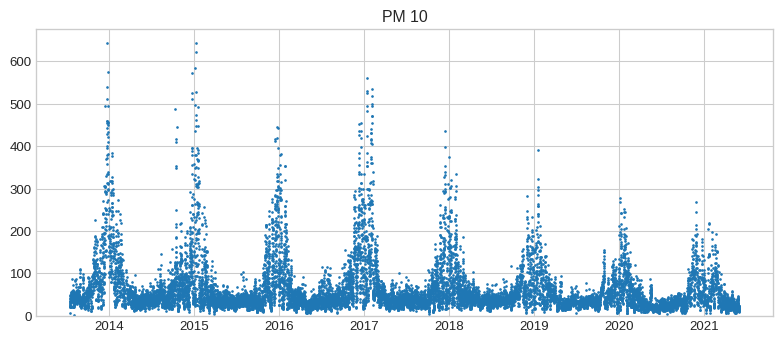

In [3]:
plt.figure(figsize=(10, 4))
plt.scatter(data.time, data.pm10, marker='.', s=4, color='C0')
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().set(title='PM 10', ylim=(0, None))
None

## Model

We are fitting a three-component model using the slow trend $a$, the monthly periodicity $s$ and the impact of the location of that measurment station, $l$, in the log-scale:

$$ \log \mu_i = a_{w_i} + s_{d_i} + l_{p_i} $$


where $w_i$, $d_i$ and $p_i$ are the overall week index, the day-of-year index and the location index at that particular data point.

The trend is treated as a gaussian random walk:

$$ a_w \sim \mathcal{N}(a_{w-1}, 0.01) $$

The monthly periodicity is modeled as an inverse fourier transform with a period 366 and order of 8:

$$ s_d = \sum_{k=1}^{8} \big(  \
  S_{k-1} \sin \frac{2 \pi k d}{366} + C_{k-1} \cos \frac{2 \pi k d}{366}  \
\big) $$

where the coefficients are given the following priors:

$$ S_k \sim \mathcal{N}(0, \frac{1}{2}) $$

$$ C_k \sim \mathcal{N}(0, \frac{1}{2}) $$

Finally, the location is treated as a category with partial pooling:
    
$$ l_p \sim \mathcal{N}(0, \kappa) $$

$$ \kappa \sim \text{Exponential}(2) $$

For the likelihood of the observations we use log-normal:

$$ \text{observed}_i \sim \text{Lognormal}(\log{\mu_i}, \rho) $$

$$ \rho \sim \text{Half-Normal}(1.5) $$

In [4]:
n_places = data.place_i.nunique()
n_weeks = data.week.max() + 1
ft_order = 8

with pm.Model() as m1:
    # trend
    a = pm.GaussianRandomWalk(
        'a', sigma=0.01, init=pm.Normal.dist(3, 1),
        shape=n_weeks)

    # location
    kappa = pm.Exponential('kappa', 1/0.5)
    l = pm.Normal('l', 0, kappa, shape=n_places)

    # monthly seasonality
    Sk = pm.Normal('Sk', mu=0, sd=0.5, shape=ft_order)
    Ck = pm.Normal('Ck', mu=0, sd=0.5, shape=ft_order)

    s = 0
    for k in range(1, ft_order):
        phi = 2 * np.pi * k * np.arange(0, 366) / 366 
        s = s + Sk[k-1] * np.sin(phi) + Ck[k-1] * np.cos(phi)
    s = pm.Deterministic('s', s)

    # pointwise
    mu_i = (
        a[data.week.values]
        + l[data.place_i.values]
        + s[data.doy.values]
    )

    # likelihood
    rho = pm.HalfNormal('rho', 1.5)
    pm.Lognormal('obs', mu_i, rho, observed=data.pm10.values)

    # computed quantities
    pm.Deterministic('trend', tt.exp(a + tt.mean(s) + rho**2/2))
    pm.Deterministic('seasonal_factor', tt.exp(s - tt.mean(s)))

    m1.trace = pm.sample(8000, tune=2000, chains=2)

<ipython-input-4-936917855ccb>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  m1.trace = pm.sample(8000, tune=2000, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [rho, Ck, Sk, l, kappa, a]


Sampling 2 chains for 2_000 tune and 8_000 draw iterations (4_000 + 16_000 draws total) took 2063 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [5]:
az.summary(m1.trace, var_names=['rho', 'kappa'])

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,0.512,0.003,0.506,0.517,0.000,0.000,29080.0,11628.0,1.0
kappa,0.161,0.066,0.073,0.278,0.001,0.001,3636.0,6027.0,1.0


/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


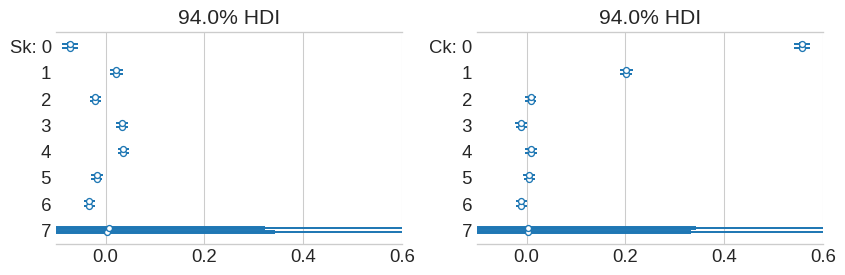

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
az.plot_forest(m1.trace, var_names=['Sk'], ax=axes[0])
az.plot_forest(m1.trace, var_names=['Ck'], ax=axes[1])
axes[0].set(xlim=(-0.1, 0.6))
axes[1].set(xlim=(-0.1, 0.6))
fig.tight_layout()
None

## Conclusions

### Estimate

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


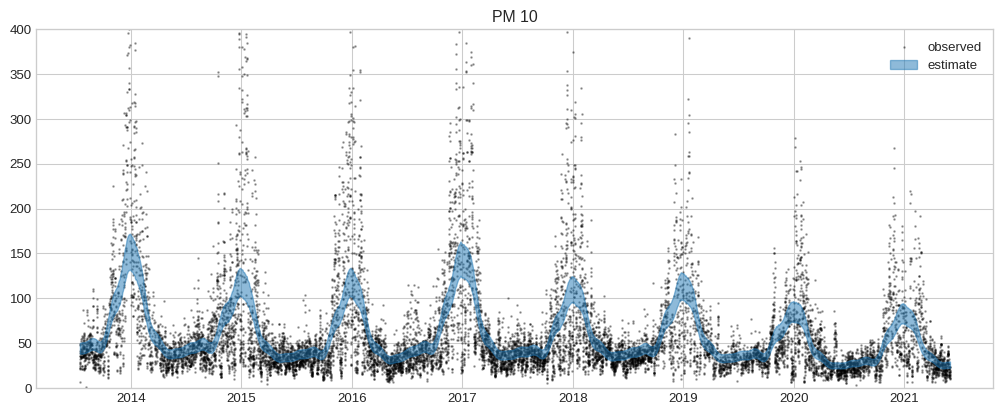

In [7]:
plt.figure(figsize=(13, 5))

plt.scatter(data.time, data.pm10,
            marker='.', s=4, color='k', label='observed', alpha=.3)

tmp_dates = data[['time', 'week', 'doy']].drop_duplicates().sort_values('time')
tmp = az.hdi(
    np.exp(
        m1.trace['a'][:, tmp_dates.week]
        + m1.trace['s'][:, tmp_dates.doy]
        + m1.trace['rho'].reshape(-1, 1) ** 2 / 2
    ),
)
plt.fill_between(tmp_dates['time'], tmp[:, 0], tmp[:, 1],
                 color='C0', label='estimate', alpha=.5)

plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().set(title='PM 10', ylim=(0, 400))
plt.legend()
None

### Location

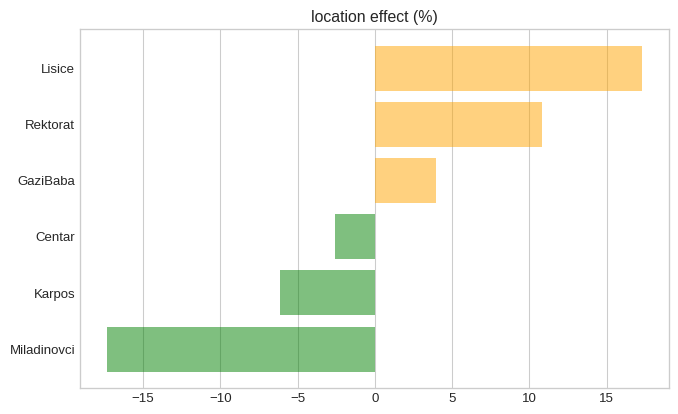

In [8]:
tmp = data[['place', 'place_i']].drop_duplicates().set_index('place_i').place.sort_index()

tmp = pd.Series(np.exp(m1.trace['l']).mean(axis=0), tmp).sort_values()
plt.barh(tmp.index, (tmp - 1) * 100,
         color=tmp.map(lambda x: 'orange' if x > 1 else 'g'),
         alpha=.5)
plt.gca().set(title='location effect (%)', ylabel='')
plt.grid(axis='y')
None

### Trend and seasonal 

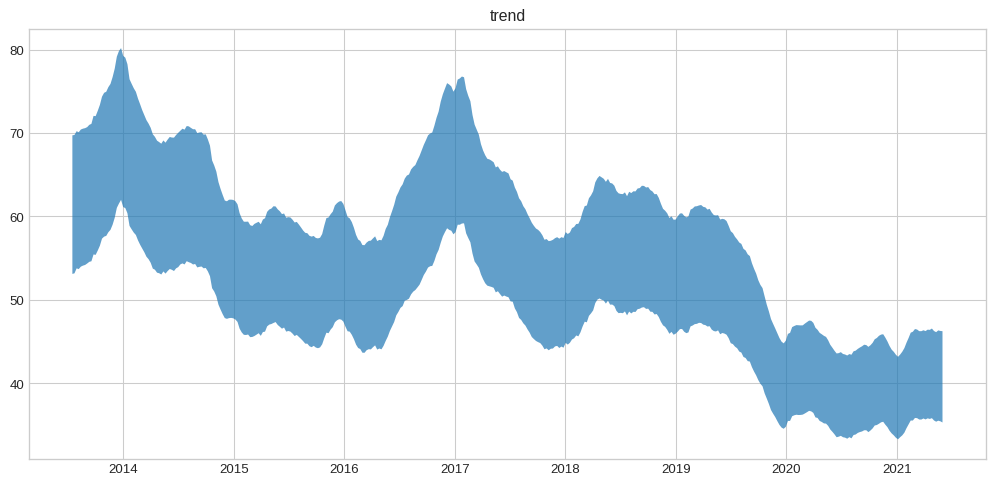

In [9]:
plt.figure(figsize=(13, 6))

tmp = az.hdi(m1.trace['trend'])
plt.fill_between(
    data.groupby('week').time.min(),
    tmp[:, 0], tmp[:, 1],
    alpha=.7, label='trend')

plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().set(title='trend')
None

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


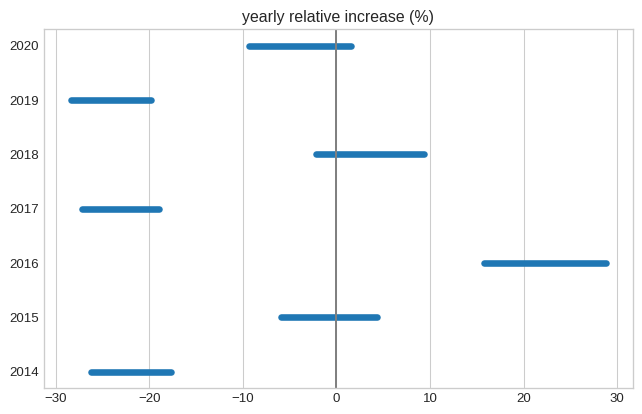

In [10]:
plt.figure(figsize=(8, 5))
tmp_dates = data[['time', 'week', 'doy']].drop_duplicates().sort_values('time')
tmp_dates = tmp_dates[(tmp_dates.time.dt.month == 1) & (tmp_dates.time.dt.day == 1)]
tmp = m1.trace['trend'][:, tmp_dates.week.values]
tmp = az.hdi(tmp[:, 1:] / tmp[:, :-1] - 1)

for i, t in enumerate(tmp_dates['time'].iloc[1:].values):
    y = pd.to_datetime(t).year - 1
    plt.plot(tmp[i] * 100, (y, y), linewidth=5, color='C0')

plt.axvline(0, color='gray')
plt.gca().set(title='yearly relative increase (%)')
plt.grid(axis='y')
None

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


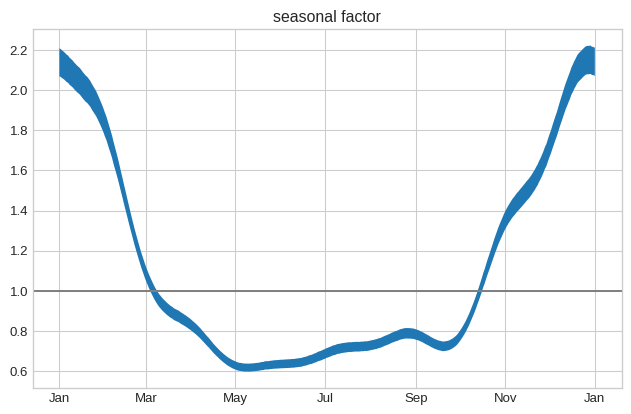

In [11]:
plt.figure(figsize=(8, 5))

tmp = az.hdi(m1.trace['seasonal_factor'])
plt.fill_between([date(2021, 1, 1) + timedelta(i) for i in range(366)],
                 tmp[:, 0], tmp[:, 1])
plt.axhline(1, color='gray')
plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))
plt.gca().set(title='seasonal factor')
None

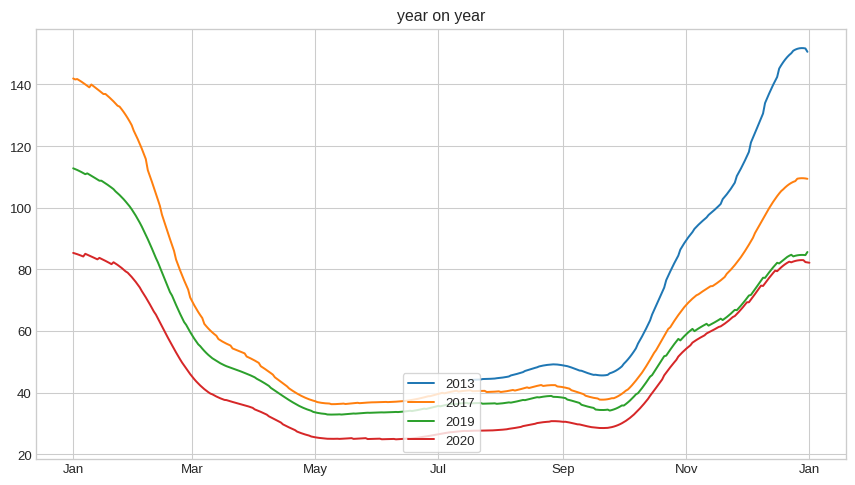

In [12]:
tmp_dates = data[['time', 'doy', 'week']].drop_duplicates().sort_values('time')
tmp = np.mean(
    np.exp(
        m1.trace['a'][:, tmp_dates.week]
        + m1.trace['s'][:, tmp_dates.doy]
        + m1.trace['rho'].reshape(-1, 1) ** 2 / 2
    ),
    axis=0
)
tmp = pd.Series(tmp).to_frame().join(tmp_dates.reset_index(drop=True))
tmp = tmp.assign(
    year = tmp.time.dt.year,
    day_index = tmp.doy.map(lambda i: date(2021, 1, 1) + timedelta(i))
)

plt.figure(figsize=(11, 6))

for i in [2013, 2017, 2019, 2020]:
    tmp_y = tmp[tmp.year == i].sort_values('doy')
    plt.plot(tmp_y.day_index, tmp_y[0], label=i)

plt.gca().set(title='year on year', xlabel='')
plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))
plt.legend(loc='lower center', frameon=True)
None

---